In [2]:
############## Data Segmentation
# Importing Necessary libraries
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

server = 'LAPTOP-LFBT0G3K'
database = 'DataWarehouse'
driver = '{ODBC Driver 18 for SQL Server}'

cnxn = None

In [23]:
# Connection and query loading
try:
    connection_string = (
        f'DRIVER={driver};'
        f'SERVER={server};'
        f'DATABASE={database};'
        'Trusted_Connection=yes;'
        'Encrypt=yes;'
        'TrustServerCertificate=yes;'
    )
    print(f"Attempting to connect to {server}/{database} using driver: {driver}")
    cnxn = pyodbc.connect(connection_string)
    print("Successfully connected to SQL Server!")
    
    sql_analysis_query="""
                            WITH category_sales AS (
                            SELECT
                                p.category,
                                SUM(f.sales_amount) AS total_sales
                            FROM gold.fact_sales f
                            LEFT JOIN gold.dim_products p
                                ON p.product_key = f.product_key
                            GROUP BY p.category
                        )
                        SELECT
                            category,
                            total_sales,
                            SUM(total_sales) OVER () AS overall_sales,
                            ROUND((CAST(total_sales AS FLOAT) / SUM(total_sales) OVER ()) * 100, 2) AS percentage_of_total
                        FROM category_sales
                        ORDER BY total_sales DESC;
    """
    df_category_sales=pd.read_sql(sql_analysis_query,cnxn)

    sql_analysis_query="""
                             WITH subcategory_sales AS (
                            SELECT
                                p.subcategory,
                                SUM(f.sales_amount) AS total_sales
                            FROM gold.fact_sales f
                            LEFT JOIN gold.dim_products p
                                ON p.product_key = f.product_key
                            GROUP BY p.subcategory
                        )
                        SELECT
                            subcategory,
                            total_sales,
                            ROUND((CAST(total_sales AS FLOAT) / SUM(total_sales) OVER ()) * 100, 2) AS percentage_of_total
                        FROM subcategory_sales
                        ORDER BY total_sales DESC;
    """
    df_subcategory_sales=pd.read_sql(sql_analysis_query,cnxn)
except pyodbc.Error as ex:
    sqlstate = ex.args[0]
    print(f"Connection or query error: {ex}")
    if 'IM002' in sqlstate:
        print(f"  --> Driver '{driver}' not found or improperly configured.")
    elif '08001' in sqlstate:
        print(f"  --> Connection failed. Verify server name, database, and network connectivity.")
    elif '28000' in sqlstate:
        print(f"  --> Authentication error. Ensure your Windows user has appropriate SQL Server permissions.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    if cnxn:
        cnxn.close()
        print("\nConnection closed.")

Attempting to connect to LAPTOP-LFBT0G3K/DataWarehouse using driver: {ODBC Driver 18 for SQL Server}
Successfully connected to SQL Server!


C:\Users\Ayush\AppData\Local\Temp\ipykernel_22600\583790743.py:33: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_category_sales=pd.read_sql(sql_analysis_query,cnxn)
C:\Users\Ayush\AppData\Local\Temp\ipykernel_22600\583790743.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_subcategory_sales=pd.read_sql(sql_analysis_query,cnxn)


In [25]:
# Testing our data
print('first 5 rows fo sales analysis Data : ')
print(df_category_sales.head())
print('\nSales Analysis Data info : ')
print(df_category_sales.info())

first 5 rows fo sales analysis Data : 
      category  total_sales  overall_sales  percentage_of_total
0        Bikes     28316272       29356250                96.46
1  Accessories       700262       29356250                 2.39
2     Clothing       339716       29356250                 1.16

Sales Analysis Data info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   category             3 non-null      object 
 1   total_sales          3 non-null      int64  
 2   overall_sales        3 non-null      int64  
 3   percentage_of_total  3 non-null      float64
dtypes: float64(1), int64(2), object(1)
memory usage: 224.0+ bytes
None


In [24]:
# Testing our data
print('first 5 rows fo sales analysis Data : ')
print(df_subcategory_sales.head())
print('\nSales Analysis Data info : ')
print(df_subcategory_sales.info())

first 5 rows fo sales analysis Data : 
       subcategory  total_sales  percentage_of_total
0       Road Bikes     14519438                49.46
1   Mountain Bikes      9952254                33.90
2    Touring Bikes      3844580                13.10
3  Tires and Tubes       244634                 0.83
4          Helmets       225435                 0.77

Sales Analysis Data info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subcategory          17 non-null     object 
 1   total_sales          17 non-null     int64  
 2   percentage_of_total  17 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 536.0+ bytes
None


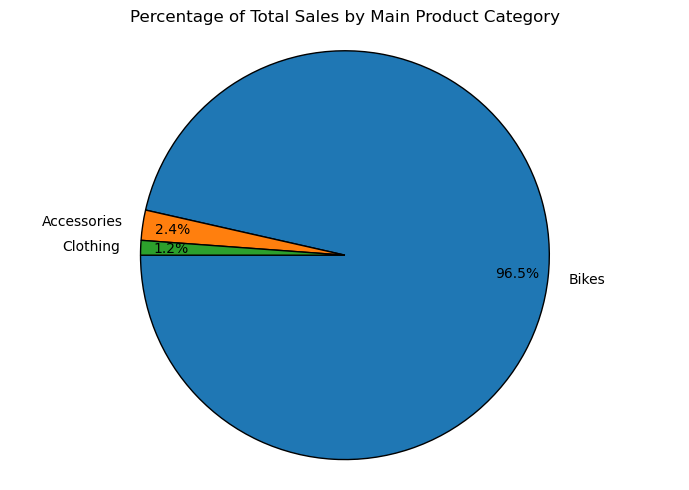

In [32]:
# Pie chart by categories
df_main_category_sales = df_category_sales.groupby('category')['total_sales'].sum().reset_index()
total_overall_sales = df_main_category_sales['total_sales'].sum()
df_main_category_sales['percentage_of_total'] = (df_main_category_sales['total_sales'] / total_overall_sales) * 100
df_main_category_sales = df_main_category_sales.sort_values(by='total_sales', ascending=False)

plt.figure(figsize=(7, 5))
min_percentage_for_slice = 2
small_categories = df_main_category_sales[df_main_category_sales['percentage_of_total'] < min_percentage_for_slice]
other_percentage = small_categories['percentage_of_total'].sum()

df_pie_chart_main = df_main_category_sales[df_main_category_sales['percentage_of_total'] >= min_percentage_for_slice].copy()
if other_percentage > 0:
    other_row = pd.DataFrame([{'category': 'Clothing', 'total_sales': 0, 'percentage_of_total': other_percentage}])
    df_pie_chart_main = pd.concat([df_pie_chart_main, other_row], ignore_index=True)
    df_pie_chart_main = df_pie_chart_main.sort_values(by='percentage_of_total', ascending=False)

plt.pie(df_pie_chart_main['percentage_of_total'],
        labels=df_pie_chart_main['category'],
        autopct='%1.1f%%',
        startangle=180,
        pctdistance=0.85,
        wedgeprops={'edgecolor': 'black'})
plt.title('Percentage of Total Sales by Main Product Category')
plt.axis('equal')
plt.tight_layout()
plt.show()

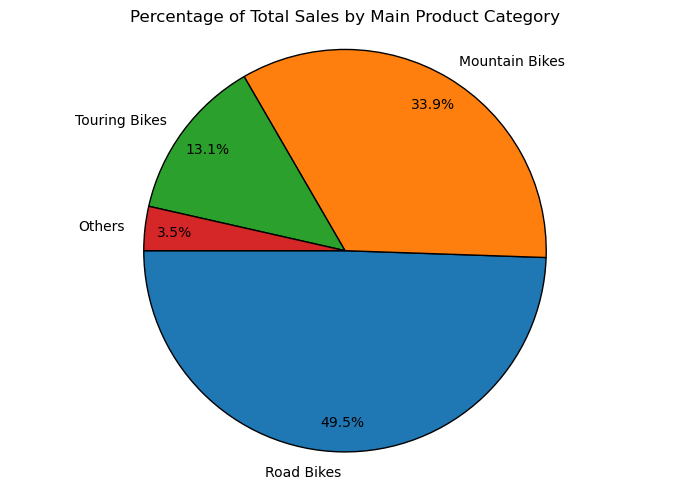

In [36]:
# pie chart by sub categories

df_main_category_sales = df_subcategory_sales.groupby('subcategory')['total_sales'].sum().reset_index()
total_overall_sales = df_main_category_sales['total_sales'].sum()
df_main_category_sales['percentage_of_total'] = (df_main_category_sales['total_sales'] / total_overall_sales) * 100
df_main_category_sales = df_main_category_sales.sort_values(by='total_sales', ascending=False)

plt.figure(figsize=(7, 5))
min_percentage_for_slice = 2
small_categories = df_main_category_sales[df_main_category_sales['percentage_of_total'] < min_percentage_for_slice]
other_percentage = small_categories['percentage_of_total'].sum()

df_pie_chart_main = df_main_category_sales[df_main_category_sales['percentage_of_total'] >= min_percentage_for_slice].copy()
if other_percentage > 0:
    other_row = pd.DataFrame([{'subcategory': 'Others', 'total_sales': 0, 'percentage_of_total': other_percentage}])
    df_pie_chart_main = pd.concat([df_pie_chart_main, other_row], ignore_index=True)
    df_pie_chart_main = df_pie_chart_main.sort_values(by='percentage_of_total', ascending=False)

plt.pie(df_pie_chart_main['percentage_of_total'],
        labels=df_pie_chart_main['subcategory'],
        autopct='%1.1f%%',
        startangle=180,
        pctdistance=0.85,
        wedgeprops={'edgecolor': 'black'})
plt.title('Percentage of Total Sales by Main Product Category')
plt.axis('equal')
plt.tight_layout()
plt.show()